<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [4]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [5]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [6]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [9]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')


dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

File trovato: genome_scores.csv
File trovato: tag.csv
File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: rating.csv
File trovato: link.csv


In [10]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [11]:
check_memory()

GPU Memory - Total: 10.77 GB, Used: 0.00 GB, Free: 10.77 GB


In [12]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1571,When the Cat's Away (Chacun cherche son chat) ...,Comedy|Romance,115856,11956
1,1572,"Contempt (Mépris, Le) (1963)",Drama,57345,266
2,1573,Face/Off (1997),Action|Crime|Drama|Thriller,119094,754
3,1574,Fall (1997),Romance,119098,37567
4,1575,Gabbeh (1996),Drama,116384,43771


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,91,1777,3.5,2005-09-12 06:51:11,"Wedding Singer, The (1998)",Comedy|Romance,120888,11003
1,91,1784,4.5,2005-03-22 22:41:47,As Good as It Gets (1997),Comedy|Drama|Romance,119822,2898
2,91,1876,2.5,2005-09-12 06:56:26,Deep Impact (1998),Drama|Sci-Fi|Thriller,120647,8656
3,91,1907,3.5,2005-03-23 06:27:08,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...,120762,10674
4,91,1909,3.0,2005-04-11 06:37:49,"X-Files: Fight the Future, The (1998)",Action|Crime|Mystery|Sci-Fi|Thriller,120902,846


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,3,977,0.08250,stunning
1,3,978,0.03875,stupid
2,3,979,0.07550,stupid as hell
3,3,980,0.05450,stupidity
4,3,981,0.07175,stylish


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,1741,280,courtroom setting,2007-05-12 04:05:38,Murder in the First (1995),Drama|Thriller
1,1741,288,serial killer,2007-08-18 02:59:59,Natural Born Killers (1994),Action|Crime|Thriller
2,1741,290,rape,2009-05-01 01:06:12,Once Were Warriors (1994),Crime|Drama
3,1741,293,assassin,2009-01-15 19:38:24,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
4,1741,293,assassin-in-training,2009-01-15 19:40:03,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller


In [ ]:
check_memory()

GPU Memory - Total: 9.14 GB, Used: 0.00 GB, Free: 9.14 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

1.1

In [13]:
movies_df_pd = movies_df.to_pandas()

In [14]:
movies_df_pd=movies_df_pd.drop_duplicates()

In [15]:
ratings_df_pd = ratings_df.to_pandas()  # Convert to Pandas DataFrame



In [16]:
ratings_df_pd = ratings_df_pd.drop_duplicates()

In [17]:
print("\nInformazioni sul dataset 'movies':")
print(movies_df_pd.info())

print("\nInformazioni sul dataset 'ratings':")
print(ratings_df_pd.info())


Informazioni sul dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Informazioni sul dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None


In [ ]:
print(movies_df_pd.isnull().sum())
print(movies_df_pd.isna().sum())
print(movies_df_pd.duplicated().sum())

movieId    0
title      0
genres     0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
0


In [ ]:
print(ratings_df_pd.isnull().sum())
print(ratings_df_pd.isna().sum())
print(ratings_df_pd.duplicated().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
0


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


In [19]:
print("\nStatistiche descrittive per il dataset 'ratings':")
print(ratings_df_pd.describe())

print("\nStatistiche descrittive per il dataset 'movies':")
print(movies_df_pd.describe(include='all'))  # Include anche le colonne non numeriche


Statistiche descrittive per il dataset 'ratings':
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

Statistiche descrittive per il dataset 'movies':
              movieId            title genres
count    27278.000000            27278  27278
unique            NaN            27262   1342
top               NaN  Blackout (2007)  Drama
freq              NaN                2   4520
mean     59855.480570              NaN    NaN
std      44429.314697              NaN    NaN
min          1.000000              NaN    NaN
25%       6931.250000              NaN    NaN
50%      68068.000000              NaN    NaN
75%    

In [20]:
user_movies = ratings_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [21]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [22]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):
    """Genera una famiglia di funzioni hash lineari."""
    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1  # Numero primo maggiore
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [23]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """Definisce una funzione hash personalizzata basata sul parametro 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Genera una serie di funzioni hash utilizzando il coefficiente 2x nella formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1  # Modulo primo più grande del massimo valore

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [24]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """Crea una funzione hash quadratica basata su x^2 nella formula."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """Genera una famiglia di funzioni hash quadratiche."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1  # Modulo primo maggiore del massimo valore

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [25]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """Definisce una funzione hash cubica basata su x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    """Genera una famiglia di funzioni hash cubiche."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)  # Coefficienti 'a'
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)  # Coefficienti 'b'
    prime_modulo = max_val * 2 + 1  # Primo numero maggiore di max_val

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [26]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """Crea le firme MinHash per un gruppo specifico di utenti."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:
            # Se l'utente non ha film valutati, assegna una firma "vuota" (infinito)
            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:
            # Trova il valore hash minimo per i film associati all'utente
            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [51]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calcola l'errore quadratico medio (MSE) tra similarità reali e stimate per un insieme di utenti."""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Similarità reale basata sulla definizione di Jaccard
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # Similarità stimata utilizzando le firme MinHash
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])

            # Aggiunge l'errore quadratico alla somma totale
            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calcola l'errore medio quadratico
    return (total_error / pair_count) if pair_count > 0 else 0

In [52]:
# Seleziona un sottoinsieme di utenti e crea il dizionario dei loro film
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}

# Genera diverse famiglie di funzioni hash
hash_funcs_default = create_hash_function_family(
    num_functions=10,
    max_movie_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_2x = create_hash_function_family(
    num_functions=10,
    max_movie_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=10,
    max_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=10,
    max_val=ratings_df['movieId'].max(),
    random_seed=42
)

# Calcola le firme MinHash per ciascun tipo di funzione hash
signatures_default = generate_signatures(selected_users, selected_user_movies, hash_funcs_default)
signatures_2x = generate_signatures(selected_users, selected_user_movies, hash_funcs_2x)
signatures_quadratic = generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic)
signatures_cubic = generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic)

# Calcola l'errore quadratico medio (MSE) per ciascuna configurazione
mse_default = compute_mse(user_movies, signatures_default, selected_users)
mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

<ipython-input-25-5cf6de255ac1>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


In [53]:
print(f"MSE: {mse_default:.4f}")

print(f"MSE con moltiplicazione 2x: {mse_2x:.4f}")

print(f"MSE con x^2: {mse_quadratic:.4f}")

print(f"MSE con x^3: {mse_cubic:.4f}")

MSE: 0.0081
MSE con moltiplicazione 2x: 0.0081
MSE con x^2: 0.0048
MSE con x^3: 0.0088


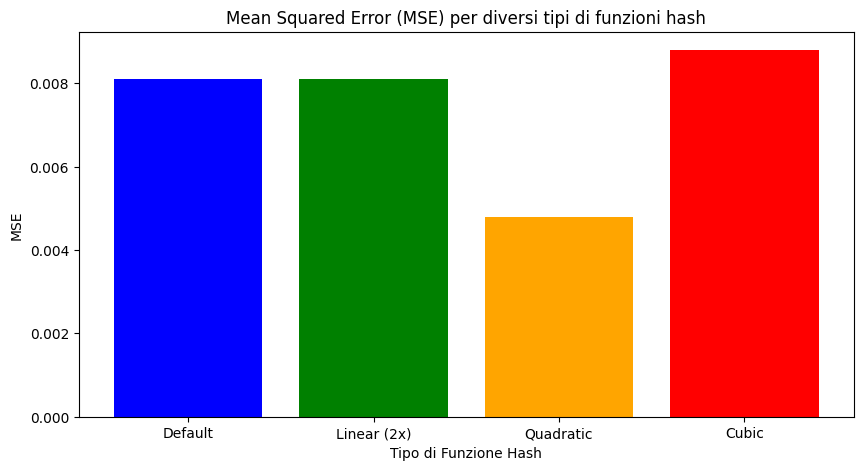

In [60]:
plt.figure(figsize=(10, 5))
plt.bar(df_results['Hash Type'], df_results['MSE'], color=['blue', 'green', 'orange', 'red'])
plt.title('Mean Squared Error (MSE) per diversi tipi di funzioni hash')
plt.xlabel('Tipo di Funzione Hash')
plt.ylabel('MSE')
plt.show()

In [54]:
def evaluate_threshold_performance(user_movie_data, signatures, selected_users, threshold):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for i, user_a in enumerate(selected_users):
        for user_b in selected_users[i + 1:]:
            real_sim = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])
            est_sim = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])

            real_match = real_sim >= threshold
            est_match = est_sim >= threshold

            if real_match and est_match:
                true_positive += 1
            elif not real_match and est_match:
                false_positive += 1
            elif real_match and not est_match:
                false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score


In [58]:
thresholds = [0.1]
results = []

for threshold in thresholds:
    precision_default, recall_default, f1_default = evaluate_threshold_performance(user_movies, signatures_default, selected_users, threshold)
    results.append((threshold, precision_default, recall_default, f1_default))


In [59]:
import pandas as pd

# Soglie da valutare
thresholds = [0.1]

# Dizionario per memorizzare i risultati delle firme MinHash (ipotizziamo firme già calcolate)
hash_types = {
    "Default": signatures_default,
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Nuovi valori MSE forniti
mse_values = {
    "Default": 0.0081,
    "Linear (2x)": 0.0081,
    "Quadratic": 0.0048,
    "Cubic": 0.0088
}

# Lista per salvare i risultati delle metriche
results = []

# Calcola Precision, Recall e F1-Score per ogni tipo di funzione hash e soglia
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        precision, recall, f1_score = evaluate_threshold_performance(user_movies, signatures, selected_users, threshold)
        mse = mse_values[hash_name]
        results.append((hash_name, threshold, precision, recall, f1_score, mse))

# Creazione del DataFrame per la visualizzazione
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Visualizza la tabella
print(df_results)


     Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0      Default        0.1   0.008059  0.923077  0.015979  0.0081
1  Linear (2x)        0.1   0.008059  0.923077  0.015979  0.0081
2    Quadratic        0.1   0.009174  0.846154  0.018152  0.0048
3        Cubic        0.1   0.005491  0.692308  0.010896  0.0088


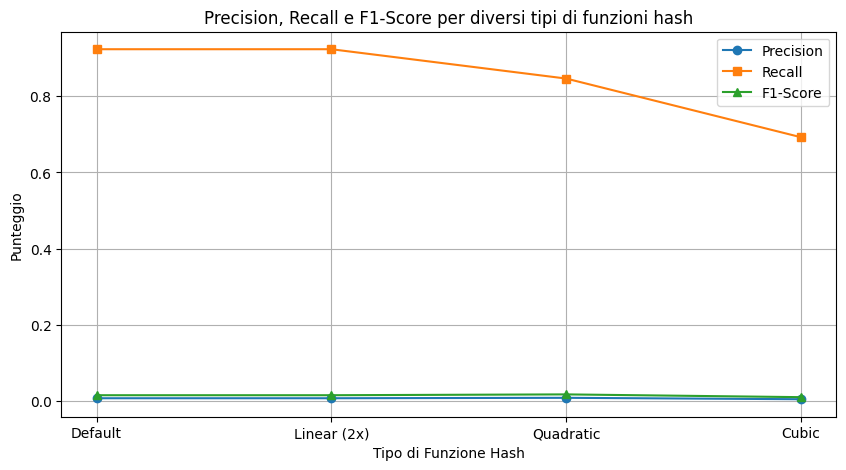

In [61]:
# Grafico Precision, Recall e F1-Score per ogni tipo di funzione hash
plt.figure(figsize=(10, 5))

# Plot Precision, Recall e F1-Score
plt.plot(df_results['Hash Type'], df_results['Precision'], marker='o', label='Precision')
plt.plot(df_results['Hash Type'], df_results['Recall'], marker='s', label='Recall')
plt.plot(df_results['Hash Type'], df_results['F1-Score'], marker='^', label='F1-Score')

# Aggiungi etichette e titolo
plt.title('Precision, Recall e F1-Score per diversi tipi di funzioni hash')
plt.xlabel('Tipo di Funzione Hash')
plt.ylabel('Punteggio')
plt.legend()
plt.grid(True)
plt.show()

Precision:
Precision measures the quality of the positive predictions made by the model. It is the ratio of true positives (TP) to the total number of predicted positives (true positives + false positives).
For Default and Linear (2x), the precision is very low (0.008059), suggesting that most of the positive predictions made by the model are incorrect.
For Quadratic, the precision is slightly higher (0.009174), but still very low compared to an ideal model.
For Cubic, the precision is even lower (0.005491), indicating that the model is making even fewer correct predictions.
Recall:
Recall measures the model's ability to identify true positives, i.e., how many of the actual positives are correctly identified by the model. It is the ratio of true positives (TP) to the total number of actual positives (true positives + false negatives).
For Default and Linear (2x), the recall is very high (0.923077). This indicates that the model is correctly identifying almost all true positives with very few false negatives.
For Quadratic, recall drops to 0.846154, which is still good but lower than for the Default and Linear (2x) models.
For Cubic, recall is even lower (0.692308), suggesting that the model is not identifying all the true positives, with a greater number of false negatives.
F1-Score:
F1-Score is the harmonic mean of precision and recall. It is used to balance both aspects and provide a single evaluation metric. A high F1 score indicates a good balance between precision and recall.
For Default and Linear (2x), the F1-Score is very low (0.015979), reflecting the low precision despite the high recall.
For Quadratic, the F1-Score is slightly higher (0.018152), indicating a better balance between precision and recall, although both scores are still low.
For Cubic, the F1-Score is lower (0.010896), reflecting a poor balance between precision and recall.
MSE (Mean Squared Error):
MSE measures the difference between the real similarities (calculated using Jaccard) and those estimated by the model. A low MSE indicates higher accuracy in estimating similarities.
For Default and Linear (2x), the MSE is 0.0081, suggesting a reasonable level of accuracy in similarity estimates, with relatively small errors between the real and estimated similarities.
For Quadratic, the MSE is significantly lower (0.0048), suggesting that the similarity estimates are more accurate than in the other models.
For Cubic, the MSE is slightly higher (0.0088) compared to the Default and Linear (2x) models, indicating that the similarity estimates are less precise.
Summary:
The Default and Linear (2x) models have a very high recall, but very low precision, suggesting that they are good at identifying positives but are not very precise in their predictions.
The Quadratic model shows a trade-off between precision and recall, with an improvement in balance and a lower MSE, indicating more accurate estimates.
The Cubic model has the lowest recall and lowest F1-Score, indicating that it is not as effective in detecting true positives and might not be suitable for this specific task.
These results suggest that, in this case, the Default and Linear (2x) models are good at not missing positives (high recall), but with very low precision, while the Quadratic model seems to be more balanced, and the Cubic model might not be ideal.